# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts learned in this section, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with polynomial features/interactions
- Perform regularization
- Use AIC and BIC to select the best value for the regularization parameter


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

from sklearn.datasets import load_boston

In [6]:
from itertools import combinations

## Look at a Baseline Boston Housing Data Model

Import the Boston housing data set, use all the predictors in their scaled version (using `preprocessing.scale`. Look at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation this time and use the $R^2$ score to evaluate the model.

In [3]:
regression = LinearRegression()
boston = load_boston()

In [4]:
y = pd.DataFrame(boston.target, columns = ["target"])
df = pd.DataFrame(boston.data, columns = boston.feature_names)

X_scaled = preprocessing.scale(df)
X_scaled = pd.DataFrame(X_scaled, columns = df.columns)

all_data = pd.concat([y,X_scaled], axis = 1)

crossvalidation = KFold(n_splits = 5, shuffle = True, random_state = 1)
baseline = np.mean(cross_val_score(regression, X_scaled, y, scoring = "r2", cv = crossvalidation))

In [5]:
baseline

0.7176324491383004

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold classification and store the $R^2$ to compare it with the baseline model.

You've created code for this before in the interactions lab, yet this time, you have scaled the variables so the outcomes may look different. 

Print the 7 most important interactions.

In [7]:
combinations = list(combinations(boston.feature_names, 2))
len(combinations)

78

In [8]:
interactions = []
data = X_scaled.copy()
for comb in combinations:
    data["interaction"] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring="r2", cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score,3)))
            
print("Top 7 interactions: %s" %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])

Top 7 interactions: [('RM', 'LSTAT', 0.783), ('RM', 'TAX', 0.775), ('RM', 'RAD', 0.77), ('RM', 'PTRATIO', 0.764), ('INDUS', 'RM', 0.757), ('NOX', 'RM', 0.746), ('RM', 'AGE', 0.742)]


In [9]:
len(interactions)

42

Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2" with var1 and var2 the two variables in the interaction.

In [10]:
df_inter = X_scaled.copy()
ls_interactions = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7]
for inter in ls_interactions:
    df_inter[inter[0]+"_"+inter[1]] =df[inter[0]]*df[inter[1]]

In [11]:
df_inter.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,RM_LSTAT,RM_TAX,RM_RAD,RM_PTRATIO,INDUS_RM,NOX_RM,RM_AGE
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,32.74350,1946.200,6.575,100.5975,15.18825,3.537350,428.6900
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,58.68794,1553.882,12.842,114.2938,45.39647,3.011449,506.6169
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,28.95555,1738.770,14.370,127.8930,50.79795,3.369765,439.0035
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,20.57412,1553.556,20.994,130.8626,15.25564,3.205084,320.5084
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,38.09351,1586.634,21.441,133.6489,15.58046,3.273326,387.3674


## Include Polynomials

Try polynomials of 2, 3 and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('DIS', 3, 0.732)`

In [12]:
from sklearn.preprocessing import PolynomialFeatures
polynomials = []
for col in df.columns:
    for degree in [2,3,4]:
        data = X_scaled.copy() #a new version of all features
        #a poly object for squared or cubed or "foured"
        poly = PolynomialFeatures(degree, include_bias=False)
        #give one column a poly
        X = poly.fit_transform(df[[col]])
        #drop the old column and add the new
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(X)], axis = 1)
        #get an R2 of al lthe features with the new column
        score = np.mean(cross_val_score(regression, data, y, scoring="r2", cv=crossvalidation))
        #record the new column if it produced a higher score than baseline
        if score > baseline: polynomials.append((col, degree, round(score,3)))
print("Top 10 polynomials: %s" %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

Top 10 polynomials: [('RM', 4, 0.8), ('RM', 2, 0.782), ('LSTAT', 4, 0.782), ('RM', 3, 0.781), ('LSTAT', 3, 0.774), ('LSTAT', 2, 0.772), ('DIS', 3, 0.737), ('DIS', 2, 0.732), ('DIS', 4, 0.731), ('TAX', 4, 0.724)]


For each variable, print out the maximum R2 possible when including Polynomials.

In [14]:
polynom.head()

,0,1,2
0,ZN,2,0.720
1,ZN,3,0.723
2,ZN,4,0.720
3,INDUS,2,0.723
4,INDUS,3,0.723


In [19]:
polynom.groupby([0]).head()

,0,1,2
0,ZN,2,0.720
1,ZN,3,0.723
2,ZN,4,0.720
3,INDUS,2,0.723
4,INDUS,3,0.723
5,INDUS,4,0.723
6,CHAS,2,0.718
7,CHAS,3,0.718
8,NOX,2,0.718
9,NOX,3,0.718


In [13]:
polynom = pd.DataFrame(polynomials)
polynom.groupby([0], sort=False)[2].max()

0
ZN         0.723
INDUS      0.723
CHAS       0.718
NOX        0.721
RM         0.800
AGE        0.722
DIS        0.737
RAD        0.719
TAX        0.724
PTRATIO    0.721
B          0.720
LSTAT      0.782
Name: 2, dtype: float64

Which two variables seem to benefit most from adding Polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best R squared compared to the baseline model. For each of the two feature, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [20]:
for col in ["RM", "LSTAT"]:
    poly = PolynomialFeatures(4, include_bias=False)
    X = poly.fit_transform(df[[col]])
    colnames= [col, col+"_"+"2", col+"_"+"3", col+"_"+"4"]
    df_inter = pd.concat([df_inter.drop(col, axis=1), 
                          pd.DataFrame(X, columns=colnames)], axis = 1)

In [21]:
X

array([[4.98000000e+00, 2.48004000e+01, 1.23505992e+02, 6.15059840e+02],
       [9.14000000e+00, 8.35396000e+01, 7.63551944e+02, 6.97886477e+03],
       [4.03000000e+00, 1.62409000e+01, 6.54508270e+01, 2.63766833e+02],
       ...,
       [5.64000000e+00, 3.18096000e+01, 1.79406144e+02, 1.01185065e+03],
       [6.48000000e+00, 4.19904000e+01, 2.72097792e+02, 1.76319369e+03],
       [7.88000000e+00, 6.20944000e+01, 4.89303872e+02, 3.85571451e+03]])

check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [22]:
df_inter.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,...,NOX_RM,RM_AGE,RM,RM_2,RM_3,RM_4,LSTAT,LSTAT_2,LSTAT_3,LSTAT_4
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,3.537350,428.6900,6.575,43.230625,284.241359,1868.886938,4.98,24.8004,123.505992,615.059840
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,3.011449,506.6169,6.421,41.229241,264.732956,1699.850313,9.14,83.5396,763.551944,6978.864768
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,3.369765,439.0035,7.185,51.624225,370.920057,2665.060607,4.03,16.2409,65.450827,263.766833
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,3.205084,320.5084,6.998,48.972004,342.706084,2398.257176,2.94,8.6436,25.412184,74.711821
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,3.273326,387.3674,7.147,51.079609,365.065966,2609.126456,5.33,28.4089,151.419437,807.065599


## Full model R-squared

Check out the R-squared of the full model.

In [23]:
full_model = np.mean(cross_val_score(regression, df_inter, y, scoring="r2", cv=crossvalidation))
full_model

0.8061116489236786

## Finding the best Lasso regularization parameter

You've learned that, when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter alpha of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

In [25]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(df_inter, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(df_inter, y)
alpha_aic_ = model_aic.alpha_

In [26]:
def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label= name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2,
                label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

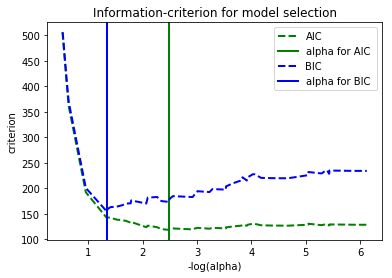

In [27]:
plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

## Analyze the final result

Finally, use the best value for regularization parameter according to AIC and BIC and compare the R squared parameters and MSE using train-test-split. Compare with the baseline model.

In [11]:
# Code for baseline model

In [12]:
# code for lasso with alpha from AIC

In [13]:
# code for lasso with alpha from BIC

## Level Up - Optional

### Create a Lasso Path

From this section, you know that when using lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-Learn there is a function lasso_path which visualizes the shrinkage of the coefficients while alpha changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Boston Housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 